**Code still being fixed**


In [27]:
from numpy import linalg 
from scipy import signal
import numpy as np 
from pylab import *
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import random
from __future__ import division

In [47]:
def GaussianFunction(x, sigma):
    if sigma == 0:
        return 0
    else:
        g = (1/math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x*x)/(2*sigma*sigma)
    return g


In [48]:
def GaussianMask(sigma):
    g = []
    for i in range(-2, 3):			#creating a gaussian kernel of size 3x3
        g1 = GaussianFunction(i,sigma)
        g2 = GaussianFunction(i-0.5, sigma)
        g3 = GaussianFunction(i+0.5, sigma)
        gaussian = (g1+g2+g3)/3
        g.append(gaussian)
    return g

In [49]:
sigma = 1.5
G = [] # Gaussian Kernel
G = GaussianMask(sigma)

In [62]:
def DownScale(I): 
    Ix = IyS = []
    I = np.array(I)
    S = np.shape(I)											#shape of the image
    for i in range(S[0]):
        Ix.extend([signal.convolve(I[i,:],G,'same')])		#convolution of the I[i] with G
    Ix = np.array(np.matrix(Ix))							
    Iy = Ix[::2, ::2]										#selects the alternate column and row
    return Iy

In [63]:
def UpScale(I):
    I = np.array(I)
    S = np.shape(I)

    Ix = np.zeros((S[0], 2*S[1]))			#inserting alternate rows of zeros
    Ix[:, ::2] = I
    S1 = np.shape(Ix)
    Iy = np.zeros((2*S1[0], S1[1]))		#inserting alternate columns of zeros
    Iy[::2, :] = Ix
    Ig = cv2.GaussianBlur(Iy, (5,5), 1.5, 1.5)		#instead of using the user-defined gaussian function, I am using the Gaussian Blur functtion for double the size of gaussian kernel size
    return Ig

In [64]:
def LucasKanade(I1, I2):
    I1 = np.array(I1)
    I2 = np.array(I2)
    S = np.shape(I1)

    Ix = signal.convolve2d(I1,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,0.25],[-0.25,0.25]],'same')
    Iy = signal.convolve2d(I1,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[0.25,0.25]],'same')
    It = signal.convolve2d(I1,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[-0.25,-0.25]],'same')

    features = cv2.goodFeaturesToTrack(I1, 10000, 0.01, 10)
    features = np.int0(features)

    u = v = np.ones((S))
    for l in features:
        j,i = l.ravel()
        IX = ([Ix[i-1,j-1],Ix[i,j-1],Ix[i-1,j-1],Ix[i-1,j],Ix[i,j],Ix[i+1,j],Ix[i-1,j+1],Ix[i,j+1],Ix[i+1,j-1]])
        IY = ([Iy[i-1,j-1],Iy[i,j-1],Iy[i-1,j-1],Iy[i-1,j],Iy[i,j],Iy[i+1,j],Iy[i-1,j+1],Iy[i,j+1],Iy[i+1,j-1]])
        IT = ([It[i-1,j-1],It[i,j-1],It[i-1,j-1],It[i-1,j],It[i,j],It[i+1,j],It[i-1,j+1],It[i,j+1],It[i+1,j-1]])

        # Using the minimum least squares solution approach
        LK = (IX,IY)
        LK = matrix(LK)
        LK_T = array(matrix(LK))
        LK = array(np.matrix.transpose(LK))

        #Psedudo Inverse
        A1 = np.dot(LK_T,LK)
        A2 = np.linalg.pinv(A1)
        A3 = np.dot(A2,LK_T)
        (u[i,j],v[i,j]) = np.dot(A3,IT) # we have the vectors with minimized square error

    u = np.flipud(u)
    v = np.flipud(v)
    return u,v

In [65]:
def LucasKanadeIterative(I1, I2, u1, v1):
    I1 = np.array(I1)
    I2 = np.array(I2)
    S = np.shape(I1)
    u1 = np.round(u1)
    v1 = np.round(v1)
    u = np.zeros(S)
    v = np.zeros(S)

    for i in range(2, S[0]-2):
        for j in range(2, S[1]-2):
            I1new = I1[i-2:i+3,j-2:j+3] 		# picking 5x5 pixels at a time
            lr = (i-2)+v1[i,j]				 	#Low Row Index
            hr = (i+2)+v1[i,j] 					#High Row Index
            lc = (j-2)+u1[i,j] 					#Low Column Index
            hc = (j+2)+u1[i,j] 					#High Column Index

            #window search and selecting the last window if it goes out of bounds
            if(lr < 0): 
                lr = 0
                hr = 4
            if(lc < 0): 
                lc = 0
                hc = 4
            if(hr > (len(I1[:,0]))-1): 
                lr = len(I1[:,0])-5
                hr = len(I1[:,0])-1                
            if(hc > (len(I1[0,:]))-1): 
                lc = len(I1[0,:])-5
                hc = len(I1[0,:])-1               
            if(np.isnan(lr)):
                lr = i-2
                hr = i+2
            if(np.isnan(lc)):
                lc = j-2
                hc = j+2
            #Selecting the same window for the second frame
            I2new = I2[int(lr):int(hr+1),int(lc):int(hc+1)]
            # Now applying LK for each window of the 2 images
            Ix = signal.convolve2d(I1new,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,0.25],[-0.25,0.25]],'same')
            Iy = signal.convolve2d(I1new,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[0.25,0.25]],'same')
            It = signal.convolve2d(I1new,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[-0.25,-0.25]],'same')

            IX =np.transpose(Ix[1:5,1:5])
            IY = np.transpose(Iy[1:5,1:5])
            IT = np.transpose(It[1:5,1:5])

            IX = IX.ravel()
            IY = IY.ravel()
            IT = IT.ravel()

            LK = (IX,IY)
            LK = np.matrix(LK)
            LK_T = np.array(np.matrix(LK))
            LK = np.array(np.matrix.transpose(LK))

            A1 = np.dot(LK_T,LK)
            A2 = np.linalg.pinv(A1)
            A3 = np.dot(A2,LK_T)
            (u[i,j],v[i,j]) = np.dot(A3,IT)
    #u = u+u1
    #v = v + v1
    r = np.mat(transpose(LK))*np.mat(LK)
    r = 1.0/(linalg.cond(r))
    return u,v,r

In [66]:
def LK_Pyramid(Im1, Im2, iteration, scale):
    I1 = np.array(Im1)
    I2 = np.array(Im2)
    S = np.shape(I1)

    pyramid1 = np.empty((S[0],S[1],scale)) 
    pyramid2 = np.empty((S[0],S[1],scale)) 
    pyramid1[:,:,0] = I1 			#since the lowest scale is the original imae
    pyramid2[:,:,0] = I2 			#since the lowest scale is the original image

    #creating the pyramid by downsampling the original image
    for i in range(1, scale):
        I1 = DownScale(I1)
        I2 = DownScale(I2)
        pyramid1[0:np.shape(I1)[0], 0:np.shape(I1)[1], i] = I1
        pyramid2[0:np.shape(I2)[0], 0:np.shape(I2)[1], i] = I2

    scale0_I1 = pyramid1[0:(len(pyramid1[:,0])//4),0:(len(pyramid1[0,:])//4),2]
    scale0_I2 = pyramid2[0:(len(pyramid2[:,0])//4),0:(len(pyramid2[0,:])//4),2]
    (u,v) = LucasKanade(Im1, Im2)

    for i in range(0, iteration):
        (u,v,r) = LucasKanadeIterative(scale0_I1, scale0_I2, u, v)
    u_l0 = u
    v_l0 = v
    I_l0 = scale0_I1
    u_l0[np.where(u_l0 == 0)] = nan
    v_l0[np.where(v_l0 == 0)] = nan

    #for scale 1
    k = 1
    u1 = UpScale(u)
    v1 = UpScale(v)
    I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(scale-k-1))),0:(len(pyramid1[0,:])//(2**(scale-k-1))),scale-k-1]
    I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(scale-k-1))),0:(len(pyramid2[0,:])//(2**(scale-k-1))),scale-k-1]
    (u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l1 = u
    v_l1 = v
    I_l1 = I1new
    u_l1[np.where(u_l1 == 0)] = nan
    v_l1[np.where(v_l1 == 0)] = nan

    k = 2
    u1 = UpScale(u)
    v1 = UpScale(v)
    I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(scale-k-1))),0:(len(pyramid1[0,:])//(2**(scale-k-1))),scale-k-1]
    I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(scale-k-1))),0:(len(pyramid2[0,:])//(2**(scale-k-1))),scale-k-1]
    (u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l2 = u
    v_l2 = v
    I_l2 = I1new
    u_l2[np.where(u_l2 == 0)] = nan
    v_l2[np.where(v_l2 == 0)] = nan

    colours = "bgrcmykw"
    colour_index = random.randrange(0,8)
    c=colours[colour_index]

    plt.figure()
    plt.imshow(I_l0,cmap = cm.gray)
    plt.title('scale 0 - Base scale')
    quiver(u_l0,v_l0,color = c)

    c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l1,cmap = cm.gray)
    plt.title('scale 1')
    quiver(u_l1,v_l1,color = c)	

    c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l2,cmap = cm.gray)
    plt.title('scale 2')
    plt.quiver(u_l2,v_l2,color = c)
    plt.show()

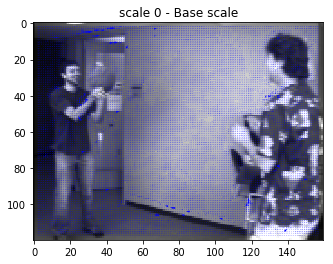

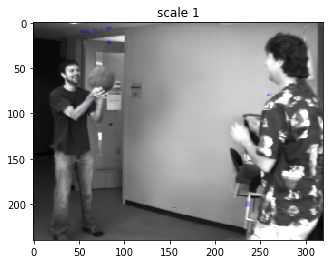

/home/harshithapv/anaconda2/envs/srikarenv/lib/python3.6/site-packages/matplotlib/quiver.py:646: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/harshithapv/anaconda2/envs/srikarenv/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/harshithapv/anaconda2/envs/srikarenv/lib/python3.6/site-packages/matplotlib/quiver.py:720: RuntimeWarning: invalid value encountered in less
  short = np.repeat(length < minsh, 8, axis=1)
/home/harshithapv/anaconda2/envs/srikarenv/lib/python3.6/site-packages/matplotlib/quiver.py:734: RuntimeWarning: invalid value encountered in less
  tooshort = length < self.minlength


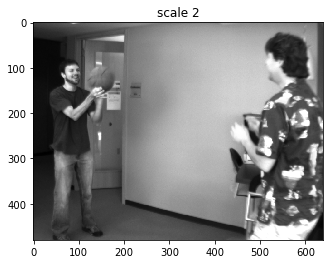

In [67]:
t = 0.3
Image1 = Image.open('/home/harshithapv/srikar cvpa2/basketball1.png').convert('L')
Image2 = Image.open('/home/harshithapv/srikar cvpa2/basketball1.png').convert('L')
LK_Pyramid(Image1, Image2, 3, 3)



In [ ]:
Image1 = Image.open('/home/harshithapv/srikar cvpa2/grove1.png').convert('L')
Image2 = Image.open('/home/harshithapv/srikar cvpa2/grove2.png').convert('L')
LK_Pyramid(Image1, Image2, 3, 3)


In [ ]:
def GaussianFunction(x, sigma):
	if sigma == 0:
		return 0
	else:
		g = (1//math.sqrt(2*math.pi*sigma*sigma))*math.exp(-x*x)//(2*sigma*sigma)
	return g

# function returns the gaussian kernel using the GaussianFunction of size 3x3
def GaussianMask(sigma):
	g = []
	for i in range(-2, 3):			#creating a gaussian kernel of size 3x3
		g1 = GaussianFunction(i,sigma)
		g2 = GaussianFunction(i-0.5, sigma)
		g3 = GaussianFunction(i+0.5, sigma)
		gaussian = (g1+g2+g3)//3
		g.append(gaussian)
	return g

sigma = 1.5
G = [] # Gaussian Kernel
G = GaussianMask(sigma)

def DownSample(I): 
	Ix = Iy  = []
	I = np.array(I)
	S = np.shape(I)											#shape of the image
	for i in range(S[0]):
		Ix.extend([signal.convolve(I[i,:],G,'same')])		#convolution of the I[i] with G
	Ix = np.array(np.matrix(Ix))							
	Iy = Ix[::2, ::2]										#selects the alternate column and row
	return Iy

def UpSample(I):
	I = np.array(I)
	S = np.shape(I)
	
	Ix = np.zeros((S[0], 2*S[1]))			#inserting alternate rows of zeros
	Ix[:, ::2] = I
	S1 = np.shape(Ix)
	Iy = np.zeros((2*S1[0], S1[1]))		#inserting alternate columns of zeros
	Iy[::2, :] = Ix
	Ig = cv2.GaussianBlur(Iy, (5,5), 1.5, 1.5)		#instead of using the user-defined gaussian function, I am using the Gaussian Blur functtion for double the size of gaussian kernel size
	return Ig

def LucasKanade(I1, I2):
	I1 = np.array(I1)
	I2 = np.array(I2)
	S = np.shape(I1)

	Ix = signal.convolve2d(I1,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,0.25],[-0.25,0.25]],'same')
	Iy = signal.convolve2d(I1,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[0.25,0.25]],'same')
	It = signal.convolve2d(I1,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2,[[-0.25,-0.25],[-0.25,-0.25]],'same')

	features = cv2.goodFeaturesToTrack(I1, 10000, 0.01, 10)
	features = np.int0(features)

	u = v = np.ones((S))
	for l in features:
		j,i = l.ravel()
		IX = ([Ix[i-1,j-1],Ix[i,j-1],Ix[i-1,j-1],Ix[i-1,j],Ix[i,j],Ix[i+1,j],Ix[i-1,j+1],Ix[i,j+1],Ix[i+1,j-1]])
		IY = ([Iy[i-1,j-1],Iy[i,j-1],Iy[i-1,j-1],Iy[i-1,j],Iy[i,j],Iy[i+1,j],Iy[i-1,j+1],Iy[i,j+1],Iy[i+1,j-1]])
		IT = ([It[i-1,j-1],It[i,j-1],It[i-1,j-1],It[i-1,j],It[i,j],It[i+1,j],It[i-1,j+1],It[i,j+1],It[i+1,j-1]])
		
		# Using the minimum least squares solution approach
		LK = (IX,IY)
		LK = matrix(LK)
		LK_T = array(matrix(LK))
		LK = array(np.matrix.transpose(LK))
		
		#Psedudo Inverse
		A1 = np.dot(LK_T,LK)
		A2 = np.linalg.pinv(A1)
		A3 = np.dot(A2,LK_T)
		(u[i,j],v[i,j]) = np.dot(A3,IT) # we have the vectors with minimized square error

	u = np.flipud(u)
	v = np.flipud(v)
	return u,v
	
def LucasKanadeIterative(I1, I2, u1, v1):
	I1 = np.array(I1)
	I2 = np.array(I2)
	S = np.shape(I1)
	u1 = np.round(u1)
	v1 = np.round(v1)
	u = np.zeros(S)
	v = np.zeros(S)
	
	for i in range(2, S[0]-2):
		for j in range(2, S[1]-2):
			I1new = I1[i-2:i+3,j-2:j+3] 		# picking 5x5 pixels at a time
			lr = (i-2)+v1[i,j]				 	#Low Row Index
			hr = (i+2)+v1[i,j] 					#High Row Index
			lc = (j-2)+u1[i,j] 					#Low Column Index
			hc = (j+2)+u1[i,j] 					#High Column Index
			
			#window search and selecting the last window if it goes out of bounds
			if(lr < 0): 
				lr = 0
				hr = 4
			if(lc < 0): 
				lc = 0
				hc = 4
			if(hr > (len(I1[:,0]))-1): 
				lr = int(len(I1[:,0])-5)
				hr = int(len(I1[:,0])-1 )               
			if(hc > (len(I1[0,:]))-1): 
				lc = int(len(I1[0,:])-5)
				hc = int(len(I1[0,:])-1)              
			if(np.isnan(lr)):
				lr = int(i-2)
				hr = int(i+2)
			if(np.isnan(lc)):
				lc = int(j-2)
				hc = int(j+2)
			#Selecting the same window for the second frame
			I2new = I2[int(lr):int(hr+1),int(lc):int(hc+1)]
			# Now applying LK for each window of the 2 images
			Ix = signal.convolve2d(I1new,[[-0.25,0.25],[-0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,0.25],[-0.25,0.25]],'same')
			Iy = signal.convolve2d(I1new,[[-0.25,-0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[0.25,0.25]],'same')
			It = signal.convolve2d(I1new,[[0.25,0.25],[0.25,0.25]],'same') + signal.convolve2d(I2new,[[-0.25,-0.25],[-0.25,-0.25]],'same')
			
			IX =np.transpose(Ix[1:5,1:5])
			IY = np.transpose(Iy[1:5,1:5])
			IT = np.transpose(It[1:5,1:5])
			
			IX = IX.ravel()
			IY = IY.ravel()
			IT = IT.ravel()
			
			LK = (IX,IY)
			LK = np.matrix(LK)
			LK_T = np.array(np.matrix(LK))
			LK = np.array(np.matrix.transpose(LK))
				
			A1 = np.dot(LK_T,LK)
			A2 = np.linalg.pinv(A1)
			A3 = np.dot(A2,LK_T)
			(u[i,j],v[i,j]) = np.dot(A3,IT)
	#u = u+u1
	#v = v + v1
	r = np.mat(transpose(LK))*np.mat(LK)
	r = 1.0//(linalg.cond(r))
	return u,v,r

def LK_Pyramid(Im1, Im2, iteration, level):
	I1 = np.array(Im1)
	I2 = np.array(Im2)
	S = np.shape(I1)

	pyramid1 = np.empty((S[0],S[1],level)) 
	pyramid2 = np.empty((S[0],S[1],level)) 
	pyramid1[:,:,0] = I1 			#since the lowest level is the original imae
	pyramid2[:,:,0] = I2 			#since the lowest level is the original image

	#creating the pyramid by downsampling the original image
	for i in range(1, level):
		I1 = DownSample(I1)
		I2 = DownSample(I2)
		pyramid1[0:np.shape(I1)[0], 0:np.shape(I1)[1], i] = I1
		pyramid2[0:np.shape(I2)[0], 0:np.shape(I2)[1], i] = I2

	level0_I1 = pyramid1[0:(len(pyramid1[:,0])//4),0:(len(pyramid1[0,:])//4),2]
	level0_I2 = pyramid2[0:(len(pyramid2[:,0])//4),0:(len(pyramid2[0,:])//4),2]
	(u,v) = LucasKanade(Im1, Im2)

	for i in range(0, iteration):
		(u,v,r) = LucasKanadeIterative(level0_I1, level0_I2, u, v)
	u_l0 = u
	v_l0 = v
	I_l0 = level0_I1
	u_l0[np.where(u_l0 == 0)] = nan
	v_l0[np.where(v_l0 == 0)] = nan

	#for level 1
	k = 1
	u1 = UpSample(u)
	v1 = UpSample(v)
	I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(level-k-1))),0:(len(pyramid1[0,:])//(2**(level-k-1))),level-k-1]
	I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(level-k-1))),0:(len(pyramid2[0,:])//(2**(level-k-1))),level-k-1]
	(u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

	u_l1 = u
	v_l1 = v
	I_l1 = I1new
	u_l1[np.where(u_l1 == 0)] = nan
	v_l1[np.where(v_l1 == 0)] = nan

	k = 2
	u1 = UpSample(u)
	v1 = UpSample(v)
	I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(level-k-1))),0:(len(pyramid1[0,:])//(2**(level-k-1))),level-k-1]
	I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(level-k-1))),0:(len(pyramid2[0,:])//(2**(level-k-1))),level-k-1]
	(u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

	u_l2 = u
	v_l2 = v
	I_l2 = I1new
	u_l2[np.where(u_l2 == 0)] = nan
	v_l2[np.where(v_l2 == 0)] = nan

	colours = "bgrcmykw"
	colour_index = random.randrange(0,8)
	c=colours[colour_index]
	
	plt.figure()
	plt.imshow(I_l0,cmap = cm.gray)
	plt.title('Level 0 - Base level')
	quiver(u_l0,v_l0,color = c)
	
	c=colours[colour_index]
	plt.figure()
	plt.imshow(I_l1,cmap = cm.gray)
	plt.title('Level 1')
	quiver(u_l1,v_l1,color = c)	
	
	c=colours[colour_index]
	plt.figure()
	plt.imshow(I_l2,cmap = cm.gray)
	plt.title('Level 2')
	plt.quiver(u_l2,v_l2,color = c)
	plt.show()
    
    
    
    
    
    
    new
    
    
    def LK_Pyramid(Im1, Im2, iteration, level):
    I1 = np.array(Im1)
    I2 = np.array(Im2)
    S = np.shape(I1)

    pyramid1 = np.empty((S[0],S[1],level)) 
    pyramid2 = np.empty((S[0],S[1],level)) 
    pyramid1[:,:,0] = I1 			#since the lowest level is the original imae
    pyramid2[:,:,0] = I2 			#since the lowest level is the original image

    #creating the pyramid by downsampling the original image
    for i in range(1, level):
        I1 = DownSample(I1)
        I2 = DownSample(I2)
        pyramid1[0:np.shape(I1)[0], 0:np.shape(I1)[1], i] = I1
        pyramid2[0:np.shape(I2)[0], 0:np.shape(I2)[1], i] = I2

    level0_I1 = pyramid1[0:(len(pyramid1[:,0])//4),0:(len(pyramid1[0,:])//4),2]
    level0_I2 = pyramid2[0:(len(pyramid2[:,0])//4),0:(len(pyramid2[0,:])//4),2]
    (u,v) = LucasKanade(Im1, Im2)

    for i in range(0, iteration):
        (u,v,r) = LucasKanadeIterative(level0_I1, level0_I2, u, v)
    u_l0 = u
    v_l0 = v
    I_l0 = level0_I1
    u_l0[np.where(u_l0 == 0)] = nan
    v_l0[np.where(v_l0 == 0)] = nan

    #for level 1
    k = 1
    u1 = UpSample(u)
    v1 = UpSample(v)
    I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(level-k-1))),0:(len(pyramid1[0,:])//(2**(level-k-1))),level-k-1]
    I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(level-k-1))),0:(len(pyramid2[0,:])//(2**(level-k-1))),level-k-1]
    (u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l1 = u
    v_l1 = v
    I_l1 = I1new
    u_l1[np.where(u_l1 == 0)] = nan
    v_l1[np.where(v_l1 == 0)] = nan

    k = 2
    u1 = UpSample(u)
    v1 = UpSample(v)
    I1new = pyramid1[0:(len(pyramid1[:,0])//(2**(level-k-1))),0:(len(pyramid1[0,:])//(2**(level-k-1))),level-k-1]
    I2new = pyramid2[0:(len(pyramid2[:,0])//(2**(level-k-1))),0:(len(pyramid2[0,:])//(2**(level-k-1))),level-k-1]
    (u,v,r) = LucasKanadeIterative(I1new, I2new, u1, v1)

    u_l2 = u
    v_l2 = v
    I_l2 = I1new
    u_l2[np.where(u_l2 == 0)] = nan
    v_l2[np.where(v_l2 == 0)] = nan

    colours = "bgrcmykw"
    colour_index = random.randrange(0,8)
    c=colours[colour_index]

    plt.figure()
    plt.imshow(I_l0,cmap = cm.gray)
    plt.title('Level 0 - Base level')
    quiver(u_l0,v_l0,color = c)

    c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l1,cmap = cm.gray)
    plt.title('Level 1')
    quiver(u_l1,v_l1,color = c)	

    c=colours[colour_index]
    plt.figure()
    plt.imshow(I_l2,cmap = cm.gray)
    plt.title('Level 2')
    plt.quiver(u_l2,v_l2,color = c)
    plt.show()